# Import Required Libraries

In [1]:
import os
import cv2
import gdcm
import numpy as np
from matplotlib import pyplot, image
from scipy import ndimage

# Read and Plot Functions 

In [2]:
def read_image(filepath):
    # Read grayscale DICOM image
    image = cv2.imread(filepath)
    return image
def generate_histogram(image):
    # Calculate Histogram
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    return histogram

In [3]:
def plot_image(image):
    imgplot = pyplot.imshow(image, cmap=pyplot.cm.bone)
    
def plot_histogram(histogram):
    # configure and draw the histogram figure
    pyplot.figure()
    pyplot.title("CT-Scan Histogram")
    pyplot.xlabel("grayscale value")
    pyplot.ylabel("pixels")
    pyplot.xlim([0, 256])
    # TODO: qual será o limite de y?
    pyplot.ylim([0, 5000])
    pyplot.plot(histogram)
    pyplot.show()

# Image Processing Functions 

In [4]:
# Remove skull/ventricle pixels (TODO: Optimize this)
def remove_skull_and_ventricles(img):
    img[np.where((img >= [250,250,250]).all(axis = 2))] = [0,0,0]
    img[np.where((img <= [100,100,100]).all(axis = 2))] = [0,0,0]
    return img

def median_filter(img):
    img = ndimage.median_filter(img, 10)
    return img

# Returns image biggest_contour and mask
def find_biggest_contour(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask 

# Remove soft tissues using biggest contour
def remove_soft_tissues(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 100, 254, 0)
    biggest_contour, mask = find_biggest_contour(thresh)
    biggest_contour_image = np.bitwise_and(imgray, mask, mask)
    return biggest_contour_image, imgray

# use threshold to isolate likely areas of bleeding
def isolate_hemorrhages(img, imgray):
    # TODO: maybe get a average value for normal cerebral mass pixel color to use on threshold lower limit
    # Global Threshold
    ret2, thresh = cv2.threshold(img, 145, 254, cv2.THRESH_BINARY)
    final_image = np.bitwise_and(imgray, thresh, thresh)
    return final_image
    
def write_processed_image(img, directory, filename):
    processed_filepath = directory + 'processed-' + filename
    cv2.imwrite(processed_filepath, img)

# Image Processing

In [5]:
directory = "/home/rodrigo/Pictures/"
filename = "hounsfield1.png"
filepath = directory + filename

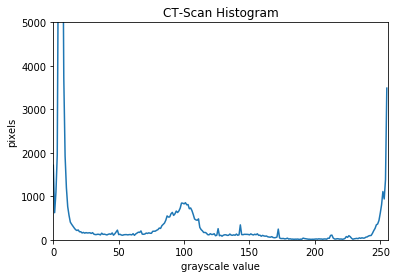

In [7]:
img = read_image(filepath)
histogram = generate_histogram(img)
plot_histogram(histogram)
img_no_skull = remove_skull_and_ventricles(img)
# plot_image(img_no_skull)
img_median_filter = median_filter(img_no_skull)
img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
final_img = isolate_hemorrhages(img_no_soft_tissues, imgray)

write_processed_image(final_img, directory, filename)